In [11]:
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import numpy as np

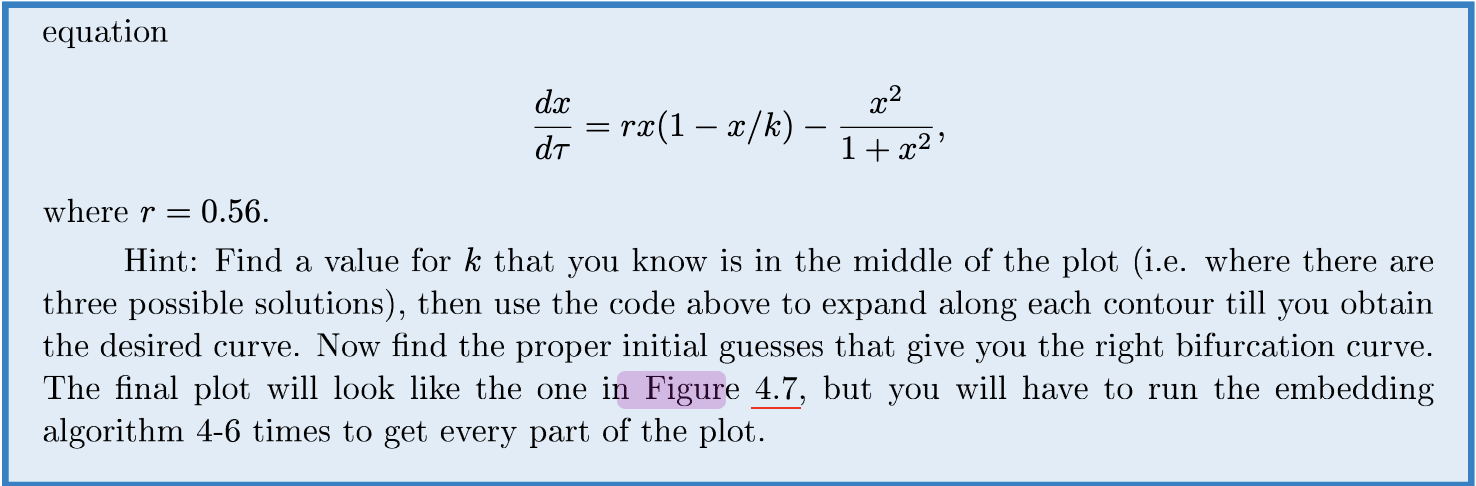

In [ ]:
# note that a factor of x has been removed to avoid x=0 solution.
def simple_hysteresis_ode(t,x,r,k):
    return r*(1-x/k)- x / (1+x**2)

Descriminant of simple hysteresis ode model

$$r (1-\frac{x}{k}) - \frac{x}{1+x^2} = 0$$
$$x = r(1+x^2)(1-\frac{x}{k})$$
$$x = r(1 - \frac{x}{k} + x^2 - \frac{x^3}{k})$$
$$0 = r - \frac{r+k}{k}x + rx^2 -r\frac{x^3}{k}$$
$$\frac{r}{k}x^3 - rx^2 + \frac{k+r}{k}x - r=0$$

In [ ]:
def descriminant(k,r):
    """
    ax^3 + bx^2 + cx + d = 0
    https://en.wikipedia.org/wiki/Cubic_equation
    """
    a = r/k
    b = -r
    c = (k+r)/k
    d = -r
    p = (3*a*c-b**2) / (3*a**2)
    q = (2*b**3 - 9*a*b*c+27*a**2*d) / (27*a**3)

    return - (4*p**3 + 27*q**2)

In [81]:
from sympy import symbols, Eq, solve, simplify

r, k = symbols('r k', positive=True)
a = r/k
b = -r
c = (k+r)/k
d = -r
p = (3*a*c-b**2) / (3*a**2)
q = (2*b**3 - 9*a*b*c+27*a**2*d) / (27*a**3)

D = - (4*p**3 + 27*q**2)
D = simplify(D)


D_fixed = D.subs(r, 0.56)
r1, r2 = solve(Eq(D_fixed, 0), k)


In [86]:
r1,r2,np.linspace(float(r1), float(r2)-0.1, 50) 

(6.44569072482332,
 9.93441120446710,
 array([6.44569072, 6.51484829, 6.58400585, 6.65316341, 6.72232097,
        6.79147853, 6.86063609, 6.92979365, 6.99895121, 7.06810877,
        7.13726633, 7.20642389, 7.27558145, 7.34473902, 7.41389658,
        7.48305414, 7.5522117 , 7.62136926, 7.69052682, 7.75968438,
        7.82884194, 7.8979995 , 7.96715706, 8.03631462, 8.10547218,
        8.17462975, 8.24378731, 8.31294487, 8.38210243, 8.45125999,
        8.52041755, 8.58957511, 8.65873267, 8.72789023, 8.79704779,
        8.86620535, 8.93536291, 9.00452047, 9.07367804, 9.1428356 ,
        9.21199316, 9.28115072, 9.35030828, 9.41946584, 9.4886234 ,
        9.55778096, 9.62693852, 9.69609608, 9.76525364, 9.8344112 ]))

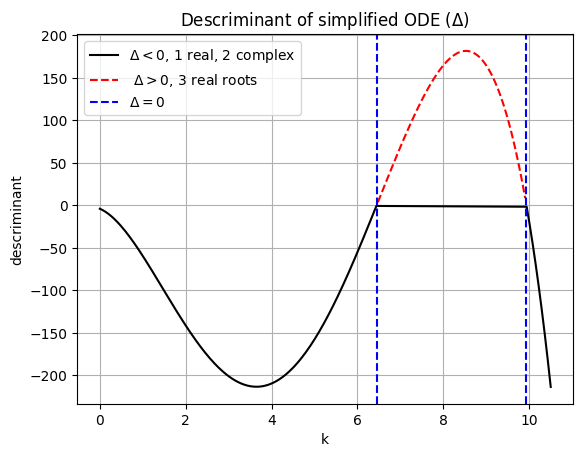

In [104]:
k = np.linspace(0+1e-15, 10.5, 301)
# k = np.linspace(-10.5,0-1e-15, 301)
des = np.array([descriminant(ki, r=0.56) for ki in k])

one_root = np.where(des<0)
three_root = np.where(des >=0)

# print(one_root)



plt.plot(k[one_root],des[one_root], c='black', label=r'$\Delta < 0$, 1 real, 2 complex')
plt.plot(k[three_root],des[three_root], linestyle='--', c='red', label=r' $\Delta > 0$, 3 real roots')
plt.axvline(r1, linestyle='--', c='blue', label=r'$\Delta=0$')
plt.axvline(r2, linestyle='--', c='blue')
plt.title(r"Descriminant of simplified ODE ($\Delta$)")
plt.xlabel("k")
plt.ylabel("descriminant")
plt.legend()
plt.grid(True)
plt.show()

for $k \in \text{supp}(\Delta > 0)$ the dynamical system exhibits 3 equilibria

where $\text{supp}(\Delta > 0) = [6.44569072482332,9.93441120446710]$ for $r=0.56$

In [101]:
# for k= 8
k = r1-0.1
r=0.56
def poly_coeff(k,r): 
    a = r/k
    b = -r
    c = (k+r)/k
    d = -r
    return [a,b,c,d]

roots = np.roots(poly_coeff(k,r))
x0 = np.min(roots)
x1 = np.max(roots)

xs = np.linspace(x0-0.5, x1+2, 201)

In [105]:
np.isreal(roots)

array([False, False,  True])

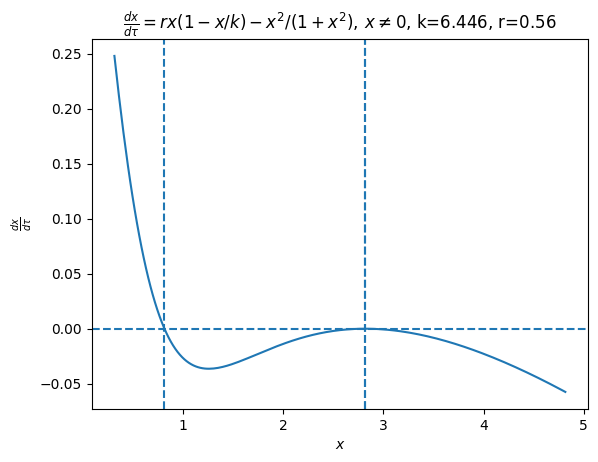

In [79]:
fig, ax = plt.subplots()

ax.plot(xs,simple_hysteresis_ode(None,xs,r,k))

for root in roots:
    ax.axvline(x=root, linestyle='--')
ax.axhline(y=0, linestyle = '--')
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$\frac{dx}{d\tau}$")

ax.set_title(r"$\frac{dx}{d \tau} = rx (1-x/k)-x^2/ (1+x^2), \: x\neq 0$, " + f"k={k:.3f}, r={r}")
plt.show()

# create movie

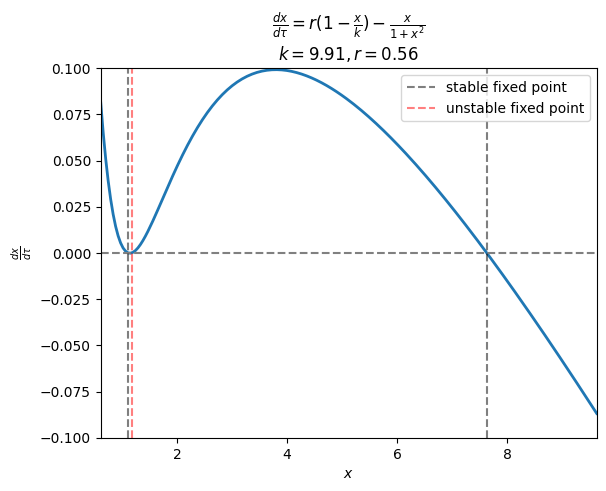

In [113]:

from matplotlib.animation import FuncAnimation, PillowWriter

# Parameters
r = 0.56
k_vals = np.linspace(float(r1), float(r2)+0.5, 100) 

def real_roots(coeffs):
    roots = np.roots(coeffs)
    return sorted([r.real for r in roots if np.isreal(r)])

# Set up plot
fig, ax = plt.subplots()
line, = ax.plot([], [], lw=2)

def init():
    ax.set_xlabel(r"$x$")
    ax.set_ylabel(r"$\frac{dx}{d\tau}$")
    return line,

def update(frame):
    k = k_vals[frame]
    coeffs = poly_coeff(k, r)
    roots = real_roots(coeffs)
    if len(roots) < 3:
        return [],
        x0=-1
        x1 = roots[0]
        xs = np.linspace(x0 - 0.5, x1 + 2, 201)
        ys = simple_hysteresis_ode(None, xs, r, k)

        ax.clear()
        ax.plot(xs, ys, lw=2)

        ax.axhline(0, color='gray', linestyle='--')

        ax.axvline(x=roots[0], color='black', linestyle='--', alpha=0.5, label="stable fixed point")

        ax.set_xlim(xs[0], xs[-1])
        ax.set_ylim(-0.1, 0.1)

        return ax.lines

    x0 = min(roots)
    x1 = max(roots)
    xs = np.linspace(x0 - 0.5, x1 + 2, 201)
    ys = simple_hysteresis_ode(None, xs, r, k)

    ax.clear()
    ax.plot(xs, ys, lw=2)

    ax.axhline(0, color='gray', linestyle='--')

    # Plot roots with labels only once
    ax.axvline(x=roots[0], color='black', linestyle='--', alpha=0.5, label="stable fixed point")
    ax.axvline(x=roots[1], color='red', linestyle='--', alpha=0.5, label="unstable fixed point")
    ax.axvline(x=roots[2], color='black', linestyle='--', alpha=0.5,)

    # Uncomment if you want to show all roots without labels (but not recommended if legend is desired)
    # for root in roots:
    #     ax.axvline(x=root, color='red', linestyle='--', alpha=0.5)

    ax.set_xlabel(r"$x$")
    ax.set_ylabel(r"$\frac{dx}{d\tau}$")
    ax.set_title(r"$\frac{dx}{d\tau} = r(1 - \frac{x}{k}) - \frac{x}{1+x^2}$" + f"\n$k={k:.2f}, r={r}$")
    ax.set_xlim(xs[0], xs[-1])
    ax.set_ylim(-0.1, 0.1)

    # Add legend in the top-right corner
    ax.legend(loc='upper right')

    return ax.lines


ani = FuncAnimation(fig, update, frames=len(k_vals), init_func=init, blit=False)
ani.save("simple_hysteresis_roots.gif", writer=PillowWriter(fps=10))


In [55]:
x0=1.7
t_span = [0,150]
t_eval = np.linspace(t_span[0],t_span[-1],501)
r=0.56
k=8
sol  = solve_ivp(simple_hysteresis_ode,t_span, [x0], args=(r,k,),t_eval=t_eval)

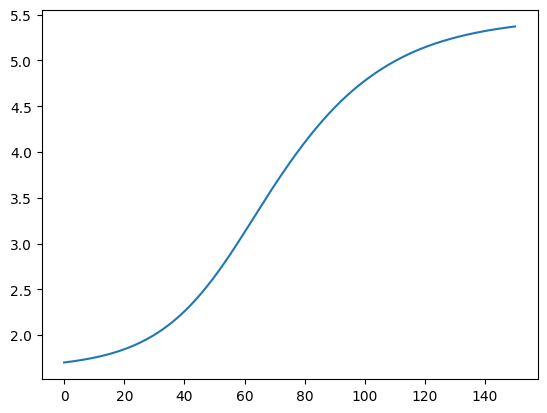

In [56]:
plt.plot(sol.t,sol.y[0])
plt.show()

In [54]:
sol.y[0][-10:]

array([0.8983454 , 0.89834089, 0.89833645, 0.89833204, 0.89832759,
       0.89832304, 0.89831832, 0.89831338, 0.89830815, 0.89830255])